In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import time
import numpy as np
import tensorflow as tf
from VGG16_GAP import VGG16_GAP
from VGG16_flatten import VGG16_flatten

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
import numpy as np
import pandas as pd
import skimage.io as imageio
import pickle

In [34]:
from progress.bar import Bar
from ipywidgets import IntProgress
from IPython.display import display

In [35]:
with open('save/label_dict.pkl', 'rb') as f:
    y_dict = pickle.load(f)

In [36]:
with open('save/inv_label_dict.pkl', 'rb') as f:
    inv_y_dict = pickle.load(f)

In [37]:
TEST_DIR = "/home/cmchang/DLCV2018SPRING/final/dlcv_final_2_dataset/test/"

In [38]:
test_list = list()
for root, subdir, files in os.walk(TEST_DIR):
    for file in sorted(files):
        if '.jpg' in file:
            test_list.append(os.path.join(TEST_DIR, file))

In [39]:
def readImgList(file_list):
    images = list()
    for i, file in enumerate(file_list):
        print(i, end="\r")
        img = imageio.imread(file)
        img = img.astype(int)
        images.append(img)
    return np.array(images)

In [40]:
def transformLabel(id_list, y_dict):
    label = list()
    for uid in list(id_list):
        label.append(y_dict[uid])
    return np.array(label)

In [41]:
def one_hot_encoding(class_numbers, num_classes):
    return np.eye(num_classes, dtype=float)[class_numbers]

In [42]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

In [43]:
Xtest = readImgList(test_list)

In [44]:
scope_name = "Model20"

In [45]:
model = VGG16_GAP(scope_name=scope_name)

In [4]:
FLAG_save_dir = "/home/cmchang/DLCV2018SPRING/final/newCL_v5_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear/"
FLAG_init_from = FLAG_save_dir + "para_dict.npy"
para_dict = np.load(FLAG_init_from, encoding='latin1').item()

In [48]:
para_dict16 = dict()
for k, v in para_dict.items():
    print(k)
    if isinstance(para_dict[k], list):
        tmp = list()
        for kv in v:
            print(kv)
            tmp.append(kv.astype(np.float16))
        para_dict16[k] = tmp
    else:
        para_dict16[k] = v.astype(np.float16)
    #para_dict16[k] = v

conv4_1_beta
conv1_2_beta
conv4_3_beta
conv1_2
[[[[ 8.41669366e-02  1.17895603e-02  1.51060551e-01 ... -7.64826015e-02
     3.39860506e-02 -4.29952592e-02]
   [ 3.74438837e-02 -1.46659389e-02 -2.31312681e-02 ... -7.63537036e-03
    -4.89930324e-02 -1.60315428e-02]
   [ 5.05100898e-02  2.85093542e-02  1.47442371e-01 ... -1.03631213e-01
    -8.91556963e-02  1.80068418e-01]
   ...
   [ 1.03628479e-01  2.24394917e-01 -3.40157305e-03 ... -3.16444486e-02
    -3.35053764e-02  1.97935067e-02]
   [-9.38464701e-02 -2.31272895e-02 -3.58197466e-02 ...  1.82982266e-01
     1.06725924e-01 -1.70981109e-01]
   [-6.54076859e-02 -1.92650817e-02 -6.63077272e-03 ... -5.67994379e-02
     1.21164590e-01 -1.02756441e-01]]

  [[ 1.52829915e-01 -3.49632725e-02  9.44703668e-02 ... -4.25909944e-02
     8.71531740e-02 -8.98570940e-02]
   [ 1.24257058e-02  4.58429335e-03 -4.82321065e-03 ...  9.87238437e-03
    -5.14029860e-02 -1.28316712e-02]
   [-1.49725582e-02 -1.05162449e-02 -4.64750640e-03 ...  7.23465905e-02


In [49]:
np.savez_compressed("test.npz", para_dict16)

In [168]:
def dpSparsifyVGG16(para_dict, dp):
    """
    dp: usage percentage of channels in each layer
    """
    first = True
    new_dict = {}
    last = 3
    for k,v in sorted(para_dict.items()):
        if 'bn_mean' in k:
            new_dict[k] = v[:int(len(v)*dp)]
            print("%s:%s" % (k, new_dict[k].shape))
        elif 'bn_variance' in k:
            new_dict[k] = v[:int(len(v)*dp)]
            print("%s:%s" % (k, new_dict[k].shape))
        elif 'gamma' in k:
            new_dict[k] = v[:int(len(v)*dp)]
            print("%s:%s" % (k, new_dict[k].shape))
        elif 'beta' in k:
            new_dict[k] = v[:int(len(v)*dp)]
            print("%s:%s" % (k, new_dict[k].shape))
        elif 'fc_2' in k:
            O = v[0].shape[0]
            new_dict[k] = [v[0][:int(O*dp),:], v[1]]
        elif 'conv' in k:
            O = v[0].shape[3]
            new_dict[k] = v[0][:,:,:last,:int(O*dp)], v[1][:int(O*dp)]
            last = int(O*dp)
            print("W%s:%s" % (k, new_dict[k][0].shape))
            print("b%s:%s" % (k, new_dict[k][1].shape))
        else:
            new_dict[k] = v
    return new_dict

In [169]:
init_model = dpSparsifyVGG16(para_dict, 1.0)

Wconv1_1:(3, 3, 3, 32)
bconv1_1:(32,)
conv1_1_beta:(32,)
conv1_1_bn_mean:(32,)
conv1_1_bn_variance:(32,)
conv1_1_gamma:(32,)
Wconv1_2:(3, 3, 32, 47)
bconv1_2:(47,)
conv1_2_beta:(47,)
conv1_2_bn_mean:(47,)
conv1_2_bn_variance:(47,)
conv1_2_gamma:(47,)
Wconv2_1:(3, 3, 47, 63)
bconv2_1:(63,)
conv2_1_beta:(63,)
conv2_1_bn_mean:(63,)
conv2_1_bn_variance:(63,)
conv2_1_gamma:(63,)
Wconv2_2:(3, 3, 63, 98)
bconv2_2:(98,)
conv2_2_beta:(98,)
conv2_2_bn_mean:(98,)
conv2_2_bn_variance:(98,)
conv2_2_gamma:(98,)
Wconv3_1:(3, 3, 98, 134)
bconv3_1:(134,)
conv3_1_beta:(134,)
conv3_1_bn_mean:(134,)
conv3_1_bn_variance:(134,)
conv3_1_gamma:(134,)
Wconv3_2:(3, 3, 134, 147)
bconv3_2:(147,)
conv3_2_beta:(147,)
conv3_2_bn_mean:(147,)
conv3_2_bn_variance:(147,)
conv3_2_gamma:(147,)
Wconv3_3:(3, 3, 147, 153)
bconv3_3:(153,)
conv3_3_beta:(153,)
conv3_3_bn_mean:(153,)
conv3_3_bn_variance:(153,)
conv3_3_gamma:(153,)
Wconv4_1:(3, 3, 153, 209)
bconv4_1:(209,)
conv4_1_beta:(209,)
conv4_1_bn_mean:(209,)
conv4_1_bn_var

In [47]:
model.build(vgg16_npy_path= para_dict16,#init_model,
            shape=Xtest.shape[1:],
            classes=len(y_dict),
            conv_pre_training=True,
            fc_pre_training=True,
            new_bn=False)

build model started
parameters loaded


ValueError: Initializer type '<dtype: 'int8'>' and explicit dtype '<dtype: 'float32'>' don't match.

In [171]:
dp = [1.0]
model.set_idp_operation(dp=dp)

DP under test: [1.]
[None, 218, 178, 3]
[None, 218, 178, 32]
AFTER [None, 218, 178, 32]
[None, 109, 89, 47]
AFTER [None, 109, 89, 47]
[None, 109, 89, 63]
AFTER [None, 109, 89, 63]
[None, 55, 45, 98]
AFTER [None, 55, 45, 98]
[None, 55, 45, 134]
AFTER [None, 55, 45, 134]
[None, 55, 45, 147]
AFTER [None, 55, 45, 147]
[None, 28, 23, 153]
AFTER [None, 28, 23, 153]
[None, 28, 23, 209]
AFTER [None, 28, 23, 209]
[None, 28, 23, 181]
AFTER [None, 28, 23, 181]
[None, 14, 12, 177]
AFTER [None, 14, 12, 177]
[None, 14, 12, 180]
AFTER [None, 14, 12, 180]
[None, 14, 12, 230]
AFTER [None, 14, 12, 230]
Set dp operations finished: 0s


In [172]:
import numpy as np

def count_number_params(para_dict):
    n = 0
    for k,v in sorted(para_dict.items()):
        if 'bn_mean' in k:
            continue
        elif 'bn_variance' in k:
            continue
        elif 'gamma' in k:
            continue
        elif 'beta' in k:
            continue
        elif 'conv' in k or 'fc' in k:
            n += get_params_shape(v[0].shape.as_list())
            n += get_params_shape(v[1].shape.as_list())
    return n

def get_params_shape(shape):
    n = 1
    for dim in shape:
        n = n*dim
    return n

def count_flops(para_dict, net_shape, input_shape=(3, 218, 178)):
    # Format:(channels, rows,cols)
    total_flops_per_layer = 0
    input_count = 0
    for k,v in sorted(para_dict.items()):
        if 'bn_mean' in k:
            continue
        elif 'bn_variance' in k:
            continue
        elif 'gamma' in k:
            continue
        elif 'beta' in k:
            continue
        elif 'fc' in k:
            continue
        elif 'conv' in k:
            conv_filter = v[0].shape.as_list()[3::-1] # (64 ,3 ,3 ,3)  # Format: (num_filters, channels, rows, cols)
            stride = 1
            padding = 1

            if conv_filter[1] == 0:
                n = conv_filter[2] * conv_filter[3] # vector_length
            else:
                n = conv_filter[1] * conv_filter[2] * conv_filter[3]  # vector_length

            flops_per_instance = n + ( n -1)    # general defination for number of flops (n: multiplications and n-1: additions)

            num_instances_per_filter = (( input_shape[1] - conv_filter[2] + 2 * padding) / stride) + 1  # for rows
            num_instances_per_filter *= ((input_shape[2] - conv_filter[3] + 2 * padding) / stride) + 1  # multiplying with cols

            flops_per_filter = num_instances_per_filter * flops_per_instance
            total_flops_per_layer += flops_per_filter * conv_filter[0]  # multiply with number of filters

            total_flops_per_layer += conv_filter[0] * input_shape[1] * input_shape[2] # bias

            input_shape = net_shape[input_count].as_list()[3:0:-1]
            input_count +=1

    total_flops_per_layer += net_shape[-1].as_list()[1] *2360*2
    return total_flops_per_layer

def countFlopsParas(net):
    total_flops = count_flops(net.para_dict, net.net_shape)
    if total_flops / 1e9 > 1:   # for Giga Flops
        print(total_flops/ 1e9 ,'{}'.format('GFlops'))
    else:
        print(total_flops / 1e6 ,'{}'.format('MFlops'))

    total_params = count_number_params(net.para_dict)

    if total_params / 1e9 > 1:   # for Giga Flops
        print(total_params/ 1e9 ,'{}'.format('G'))
    else:
        print(total_params / 1e6 ,'{}'.format('M'))
    
    return total_flops, total_params

In [173]:
flops, params = countFlopsParas(model)
print("Flops: %3f M, Paras: %3f M" % (flops/1e6, params/1e6))
FLAG_flops_M = flops/1e6
FLAG_params_M = params/1e6

6.875544996 GFlops
4.048755 M
Flops: 6875.544996 M, Paras: 4.048755 M


In [174]:
flops, params = countFlopsParas(model)
print("Flops: %3f M, Paras: %3f M" % (flops/1e6, params/1e6))
FLAG_flops_M = flops/1e6
FLAG_params_M = params/1e6

6.875544996 GFlops
4.048755 M
Flops: 6875.544996 M, Paras: 4.048755 M


In [175]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.global_variables())
    print("Initialized")
    output = []
    for dp_i in dp:
        for i in range(int(Xtest.shape[0]/200+1)):
            print(i, end="\r")
            st = i*200
            ed = min((i+1)*200, Xtest.shape[0])
            prob = sess.run(model.prob_dict[str(int(dp_i*100))], feed_dict={model.x: Xtest[st:ed,:], 
                                                                        model.is_train: False})
            output.append(prob)

Initialized


In [176]:
pred_prob = np.concatenate(output)
pred_class = np.argmax(pred_prob, 1)
final_id = list()
for pred in pred_class:
    final_id.append(inv_y_dict[pred])

In [177]:
doutput = pd.DataFrame({'id':np.arange(len(final_id))+1,
              'ans':final_id}, columns=['id','ans'])

In [178]:
doutput.to_csv("pred_val8647_final_newCL_v5_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear.csv",index=False)

In [128]:
a = np.load("/home/cmchang/DLCV2018SPRING/final/finetune_gap_v3_rescale0-1_save_linear/sparse_dict.npy", encoding='latin1').item()

In [130]:
gamma = list()
for k, v in sorted(a.items()):
    if 'gamma' in k:
        mystr = k+',"'
        for i in a[k]:
            mystr = mystr+str(i)+","
        mystr = mystr+'"'
        print(mystr)
        gamma.append(mystr)

conv1_1_gamma,"0.8048438,0.43853712,0.2708575,0.4547247,0.43879712,0.30700776,0.1892286,0.24995211,0.26699254,0.35306394,0.5614148,0.14803678,0.22068416,0.3824262,0.26773003,0.21664014,0.270334,0.19478774,0.31565794,0.43211126,0.21586078,0.15283328,0.14623973,0.16201775,0.1030869,0.24381204,0.13138768,0.13310198,0.11331141,"
conv1_2_gamma,"0.62082165,0.6491157,0.28445265,0.3966494,0.26616594,0.2635094,0.28303874,0.55703783,0.19833195,0.55193114,0.35353762,0.472334,0.2831763,0.1856772,0.4942533,0.6736985,0.34512687,0.22100103,0.5284864,0.15736358,0.58704835,0.32780108,0.14881432,0.2899597,0.3502965,0.2874378,0.18449858,0.30018145,0.104701616,0.17152037,0.1300239,0.14576362,"
conv2_1_gamma,"0.15050088,0.20958775,0.38086972,0.2443068,0.10153916,0.14321986,0.18257737,0.2762629,0.15185936,0.23334956,0.29502642,0.12148009,0.15651889,0.19852033,0.14237097,0.19490607,0.122290134,0.114403866,0.17397834,0.21742038,0.101723105,0.13947795,0.11913943,0.14746001,0.14525521,0.12265566,0.10921186,0.11

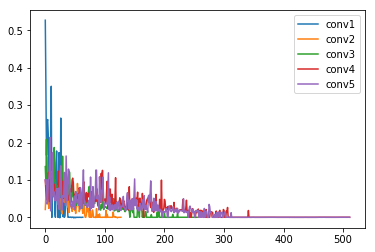

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(a['conv1_1_gamma'])), a['conv1_1_gamma'], label="conv1")
plt.plot(range(len(a['conv2_1_gamma'])), a['conv2_1_gamma'], label="conv2")
plt.plot(range(len(a['conv3_1_gamma'])), a['conv3_1_gamma'], label="conv3")
plt.plot(range(len(a['conv4_1_gamma'])), a['conv4_1_gamma'], label="conv4")
plt.plot(range(len(a['conv5_1_gamma'])), a['conv5_1_gamma'], label="conv5")
plt.legend()

In [105]:
with open(os.path.join(FLAG_save_dir, "gamma.csv"),'a') as resultFile:
    wr = csv.writer(resultFile)
    wr.writerow(gamma)

In [ ]:
HOME_DIR = "/home/cmchang/DLCV2018SPRING/final/"
VALID_DIR = HOME_DIR+"dlcv_final_2_dataset/val/"

In [ ]:
dvalid = pd.read_csv(HOME_DIR+"dlcv_final_2_dataset/val_id.txt", header=None,sep=" ", names=["img", "id"])

In [ ]:
valid_list = list(VALID_DIR+dvalid.img)

In [ ]:
Xvalid = readImgList(valid_list)

In [ ]:
yvalid = transformLabel(list(dvalid.id), y_dict)

In [ ]:
Yvalid = one_hot_encoding(yvalid, len(y_dict))

In [ ]:
batch_size = 200
with tf.Session() as sess:
    with tf.variable_scope(name_or_scope=scope_name) as scop:
        sess.run(tf.global_variables_initializer())
         # validation
        val_accu = 0
        for i in range(int(Xvalid.shape[0]/batch_size)):
            print(i, end='\r')
            st = i*batch_size
            ed = (i+1)*batch_size
            accu = sess.run(model.accu_dict['100'],
                                feed_dict={model.x: Xvalid[st:ed,:],
                                            model.y: Yvalid[st:ed,:],
                                            model.is_train: False})
            val_accu += accu
        val_accu = val_accu/int(Xvalid.shape[0]/batch_size)
        print("val accu : %.4f" % ( val_accu))
    

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
FLAG_save_dir = "/home/cmchang/DLCV2018SPRING/final/finetune_gap_v3_rescale0-1_save_linear/"

In [14]:
a = np.load(FLAG_save_dir+"para_dict.npy", encoding="latin1").item()

In [26]:
th = 5e-2

In [27]:
def gammaSparsifyVGG16(para_dict, thresh=0.5):
    last = None
    sparse_dict = {}
    N_total, N_remain = 0., 0.
    for k, v in sorted(para_dict.items()):
        if 'gamma' in k:
            # trim networks based on gamma
            gamma = v                      
            this = np.where(np.abs(gamma) > thresh)[0]
            sparse_dict[k] = gamma[this] 
            
            # get the layer name
            key = str.split(k,'_gamma')[0]
            
            # trim conv
            conv_, bias_ = para_dict[key]
            conv_ = conv_[:,:,:,this]
            if last is not None:
                conv_ = conv_[:,:,last,:]
            bias_ = bias_[this]
            sparse_dict[key] = [conv_, bias_]
            
            # get corresponding beta, bn_mean, bn_variance
            sparse_dict[key+"_beta"] = para_dict[key+"_beta"][this]
            sparse_dict[key+"_bn_mean"] = para_dict[key+"_bn_mean"][this]
            sparse_dict[key+"_bn_variance"] = para_dict[key+"_bn_variance"][this]
            
            # update
            last = this
            print('%s from %s to %s : %s ' % (k, len(gamma), len(this), len(this)/len(gamma)))
            N_total += len(gamma)
            N_remain += len(this)
    print('sparsify %s percentage' % (N_remain/N_total))
    W_, b_ = para_dict['fc_2']
    W_ = W_[last,:]
    sparse_dict['fc_2'] = [W_, b_]
    return sparse_dict, N_remain/N_total

In [28]:
b, r = gammaSparsifyVGG16(para_dict=a, thresh=th)

conv1_1_gamma from 64 to 32 : 0.5 
conv1_2_gamma from 64 to 47 : 0.734375 
conv2_1_gamma from 128 to 63 : 0.4921875 
conv2_2_gamma from 128 to 98 : 0.765625 
conv3_1_gamma from 256 to 134 : 0.5234375 
conv3_2_gamma from 256 to 147 : 0.57421875 
conv3_3_gamma from 256 to 153 : 0.59765625 
conv4_1_gamma from 512 to 209 : 0.408203125 
conv4_2_gamma from 512 to 181 : 0.353515625 
conv4_3_gamma from 512 to 177 : 0.345703125 
conv5_1_gamma from 512 to 180 : 0.3515625 
conv5_2_gamma from 512 to 230 : 0.44921875 
conv5_3_gamma from 512 to 423 : 0.826171875 
sparsify 0.4910037878787879 percentage


In [24]:
x = np.load("/home/cmchang/DLCV2018SPRING/final/finetune_gap_v3_rescale0-1_save_linear/sparse_dict_0.05.npy", encoding='latin1').item()

In [25]:
len(x['conv5_3_gamma'])

423

In [ ]:
np.save(os.path.join(FLAG_save_dir, "sparse_dict_"+str(th)+".npy"), b)

In [ ]:
# plt.plot(range(len(a['conv1_1_gamma'])), a['conv1_1_gamma'], label="conv1")
# plt.plot(range(len(a['conv2_1_gamma'])), a['conv2_1_gamma'], label="conv2")
# plt.plot(range(len(a['conv3_1_gamma'])), a['conv3_1_gamma'], label="conv3")
# plt.plot(range(len(a['conv4_1_gamma'])), a['conv4_1_gamma'], label="conv4")
# plt.plot(range(len(a['conv5_1_gamma'])), a['conv5_2_gamma'], label="conv5")
plt.legend()